# Residual Sequence Fusion (LSTM)

In [1]:
import os, sys, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
plt.rcParams["figure.dpi"] = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
root = Path("/home/gurman_preet_526_gmail_com/lusnar_slam")
res_feat = root / "results_features"
data = np.load(res_feat / "features_mm.npz")
feat_all_norm = data["feat_all_norm"]
feat_mean = data["feat_mean"]
feat_std = data["feat_std"]
t_gt = data["t_gt"]
t_cam = data["t_cam"]
t_lidar = data["t_lidar"]
fitness_arr = data["fitness_arr"]
rmse_arr = data["rmse_arr"]
imu_arr = data["imu_arr"]
N = int(data["N"])
feat_all_norm = feat_all_norm[:N]
t_gt = t_gt[:N]
t_lidar = t_lidar[:N]
print("Frames:", N, "Feat shape:", feat_all_norm.shape)

Frames: 600 Feat shape: (600, 14)


In [3]:
def translation_rmse(pred, gt):
    diff = pred - gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

In [4]:
SEQ_LEN = 20
class ResidualSeqDataset(Dataset):
    def __init__(self, feat_norm, t_gt, t_lidar, seq_len):
        self.feat = feat_norm.astype(np.float32)
        self.t_gt = t_gt.astype(np.float32)
        self.t_lidar = t_lidar.astype(np.float32)
        self.seq_len = seq_len
        self.N = self.feat.shape[0] - seq_len + 1
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        x_seq = self.feat[idx : idx + self.seq_len]
        k = idx + self.seq_len - 1
        lidar_last = self.t_lidar[k]
        gt_last = self.t_gt[k]
        return (
            torch.from_numpy(x_seq),
            torch.from_numpy(lidar_last),
            torch.from_numpy(gt_last),
        )
seq_ds = ResidualSeqDataset(feat_all_norm, t_gt, t_lidar, SEQ_LEN)
val_ratio = 0.2
n_total = len(seq_ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
seq_train, seq_val = random_split(seq_ds, [n_train, n_val])
train_loader = DataLoader(seq_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(seq_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print("Train/Val samples:", len(seq_train), len(seq_val))

Train/Val samples: 465 116


In [5]:
class ResidualSeqFusionNet(nn.Module):
    def __init__(self, feat_dim, hidden_dim=64, num_layers=2, out_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.head = nn.Sequential(
            nn.Linear(2 * hidden_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, out_dim),
        )
    def forward(self, x_seq):
        out, _ = self.lstm(x_seq)
        last = out[:, -1, :]
        delta_t = self.head(last)
        return delta_t
F = feat_all_norm.shape[1]
seq_model = ResidualSeqFusionNet(feat_dim=F, hidden_dim=64, num_layers=2, out_dim=3).to(device)
criterion_fuse = nn.MSELoss()
optimizer_fuse = torch.optim.Adam(seq_model.parameters(), lr=1e-3, weight_decay=1e-5)
print("Params (M):", sum(p.numel() for p in seq_model.parameters()) / 1e6)

Params (M): 0.148739


[Fusion] Epoch 01/20 | train=24.389441 | val=22.542458
[Fusion] Epoch 02/20 | train=14.316532 | val=4.263028
[Fusion] Epoch 03/20 | train=3.223016 | val=1.671065
[Fusion] Epoch 04/20 | train=1.994991 | val=1.079379
[Fusion] Epoch 05/20 | train=1.381360 | val=0.824989
[Fusion] Epoch 06/20 | train=1.179430 | val=0.685508
[Fusion] Epoch 07/20 | train=1.033947 | val=0.529575
[Fusion] Epoch 08/20 | train=0.855501 | val=0.404454
[Fusion] Epoch 09/20 | train=0.765844 | val=0.411310
[Fusion] Epoch 10/20 | train=0.733640 | val=0.335145
[Fusion] Epoch 11/20 | train=0.709842 | val=0.352087
[Fusion] Epoch 12/20 | train=0.651849 | val=0.319322
[Fusion] Epoch 13/20 | train=0.652795 | val=0.320355
[Fusion] Epoch 14/20 | train=0.633672 | val=0.318792
[Fusion] Epoch 15/20 | train=0.642698 | val=0.312504
[Fusion] Epoch 16/20 | train=0.616268 | val=0.302628
[Fusion] Epoch 17/20 | train=0.577263 | val=0.329604
[Fusion] Epoch 18/20 | train=0.600693 | val=0.326571
[Fusion] Epoch 19/20 | train=0.612086 | val

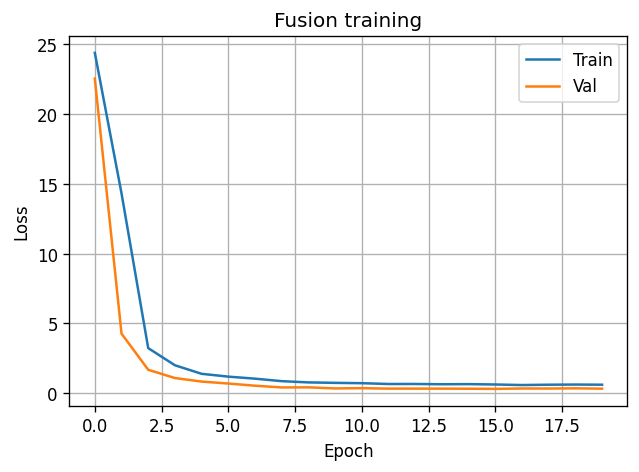

In [6]:
def run_epoch_residual(loader, model, optimizer=None, lambda_delta=1e-2):
    if optimizer is None:
        model.eval()
    else:
        model.train()
    total_loss = 0.0
    n = 0
    for x_seq, lidar_last, gt_last in loader:
        x_seq = x_seq.to(device)
        lidar_last = lidar_last.to(device)
        gt_last = gt_last.to(device)
        if optimizer is not None:
            optimizer.zero_grad()
        delta = model(x_seq)
        t_pred = lidar_last + delta
        mse_term = criterion_fuse(t_pred, gt_last)
        reg_term = (delta ** 2).mean()
        loss = mse_term + lambda_delta * reg_term
        if optimizer is not None:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x_seq.size(0)
        n += x_seq.size(0)
    return total_loss / n
NUM_EPOCHS_FUSE = 20
train_losses_fuse, val_losses_fuse = [], []
for epoch in range(1, NUM_EPOCHS_FUSE + 1):
    train_loss = run_epoch_residual(train_loader, seq_model, optimizer_fuse)
    val_loss = run_epoch_residual(val_loader, seq_model, optimizer=None)
    train_losses_fuse.append(train_loss)
    val_losses_fuse.append(val_loss)
    print(f"[Fusion] Epoch {epoch:02d}/{NUM_EPOCHS_FUSE} | train={train_loss:.6f} | val={val_loss:.6f}")
plt.figure(figsize=(6,4))
plt.plot(train_losses_fuse, label="Train")
plt.plot(val_losses_fuse, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fusion training")
plt.grid(True)
plt.legend()
plt.show()

Fused RMSE [m]: 0.42188815060317403


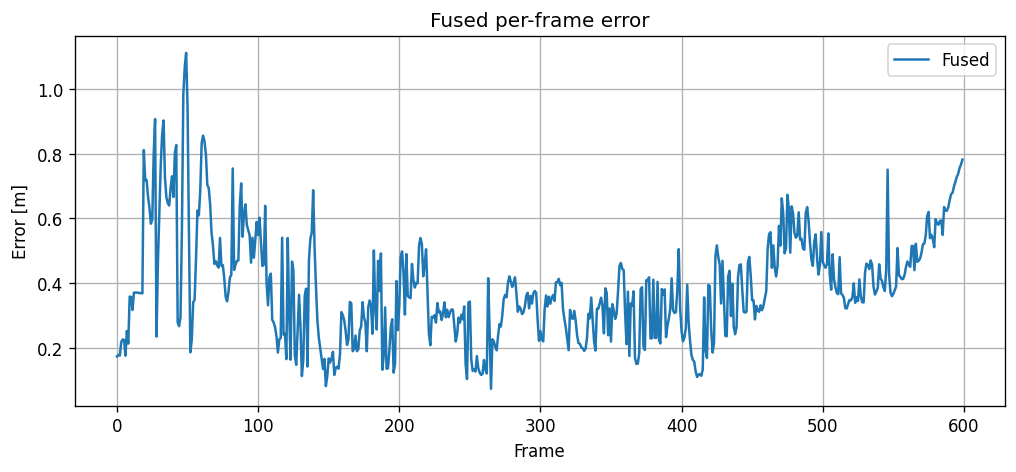

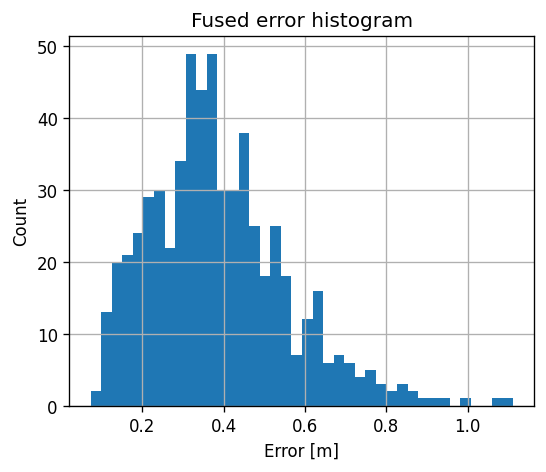

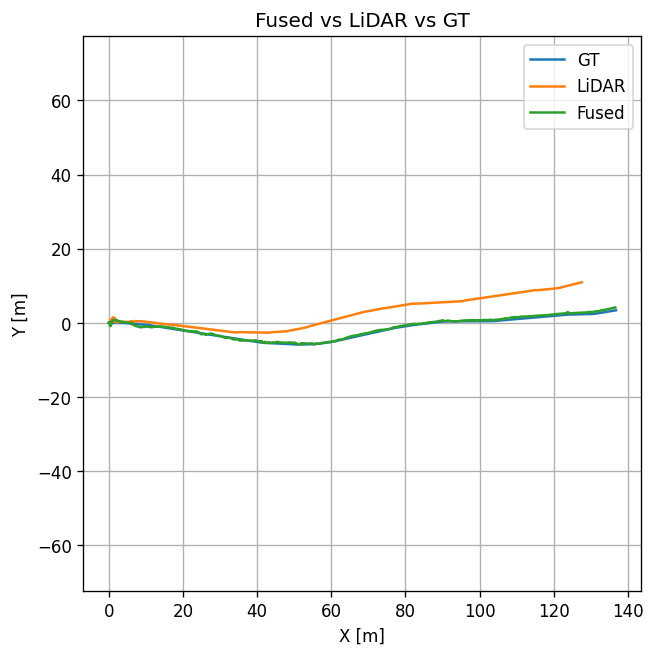

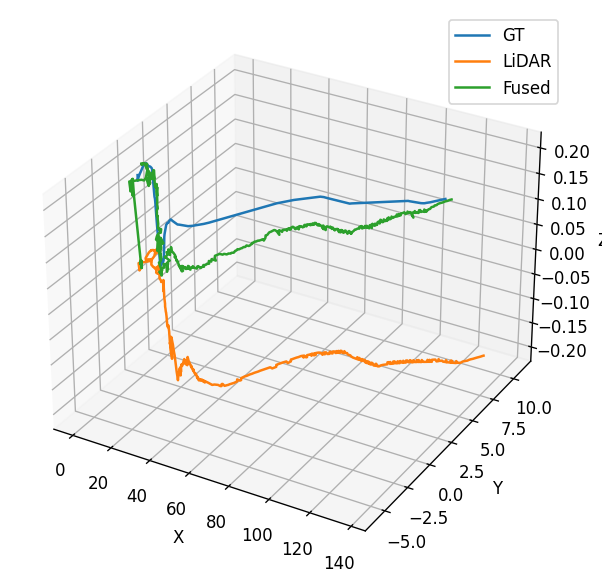

NameError: name 'err_lidar' is not defined

<Figure size 720x600 with 0 Axes>

In [7]:
seq_model.eval()
t_fused = t_lidar.copy().astype(np.float32)
with torch.no_grad():
    for i in range(N - SEQ_LEN + 1):
        x_seq = feat_all_norm[i : i + SEQ_LEN]
        x_seq_t = torch.from_numpy(x_seq).unsqueeze(0).to(device)
        delta = seq_model(x_seq_t)
        delta_np = delta.cpu().numpy()[0]
        k = i + SEQ_LEN - 1
        t_fused[k] = t_lidar[k] + delta_np
rmse_fused, err_fused = translation_rmse(t_fused, t_gt)
print("Fused RMSE [m]:", rmse_fused)
frames = np.arange(N)
plt.figure(figsize=(10,4))
plt.plot(frames, err_fused, label="Fused")
plt.xlabel("Frame")
plt.ylabel("Error [m]")
plt.title("Fused per-frame error")
plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(5,4))
plt.hist(err_fused, bins=40)
plt.xlabel("Error [m]")
plt.ylabel("Count")
plt.title("Fused error histogram")
plt.grid(True)
plt.show()
plt.figure(figsize=(6,6))
plt.plot(t_gt[:,0], t_gt[:,1], label="GT")
plt.plot(t_lidar[:,0], t_lidar[:,1], label="LiDAR")
plt.plot(t_fused[:,0], t_fused[:,1], label="Fused")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Fused vs LiDAR vs GT")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(t_gt[:,0], t_gt[:,1], t_gt[:,2], label="GT")
ax.plot(t_lidar[:,0], t_lidar[:,1], t_lidar[:,2], label="LiDAR")
ax.plot(t_fused[:,0], t_fused[:,1], t_fused[:,2], label="Fused")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
plt.figure(figsize=(6,5))
plt.scatter(err_lidar, err_fused, s=5, alpha=0.6)
plt.xlabel("LiDAR error [m]")
plt.ylabel("Fused error [m]")
plt.title("LiDAR vs Fused error")
plt.grid(True)
plt.show()

In [8]:
out_dir = root / "results_fusion"
out_dir.mkdir(parents=True, exist_ok=True)
np.save(out_dir / "t_gt.npy", t_gt)
np.save(out_dir / "t_lidar.npy", t_lidar)
np.save(out_dir / "t_fused.npy", t_fused)
np.save(out_dir / "err_fused.npy", err_fused)
np.savez(out_dir / "metrics_fusion.npz", rmse_fused=rmse_fused, N=N, seq_len=SEQ_LEN)
print("Saved to", out_dir)

Saved to /home/gurman_preet_526_gmail_com/lusnar_slam/results_fusion
